In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib
matplotlib.style.use('seaborn')

from draftbot import Draft
from itertools import repeat

In [2]:
draft = Draft()
drafters = draft.draft()

In [3]:
drafter = drafters[0]

In [4]:
def history_to_dataframe(history):
    archytypes = list(history[0].keys())
    history_array = np.zeros((len(history), len(archytypes)))
    history_df = pd.DataFrame(history_array, columns=archytypes)
    for idx, preferences in enumerate(history):
        for arch, pref in preferences.items():
            history_df.loc[history_df.index[idx], arch] = pref
    return history_df

In [18]:
def make_archytype_color_mapping(alpha):
    arch_color_mapping = {
        'W': [1, 0.8, 0.5, alpha],
        'U': [0, 0, 1, alpha],
        'B': [0, 0, 0, alpha],
        'R': [1, 0, 0, alpha],
        'G': [0, 0.8, 0, alpha]
    }
    return arch_color_mapping

def plot_alternating_color_line(ax, x, y, colors):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    segment_boundaries = np.arange(x.min(), x.max() + 1)
    n_bins = len(segment_boundaries) - 1
    cmap = ListedColormap((colors*n_bins)[:n_bins])
    norm = BoundaryNorm(segment_boundaries, cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    
def make_archytype_colors(arch, alpha=1):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    return [arch_color_mapping[c] for c in arch]

In [43]:
def plot_color_identity_dot(ax, x, y, color_identity, alpha=1.0):
    arch_color_mapping = make_archytype_color_mapping(alpha)
    colors = [arch_color_mapping[c] for c in color_identity]
    if len(colors) == 0:
        ax.scatter(x, y, c=['grey'], s=100, zorder=2)
    if len(colors) == 1:
        ax.scatter(x, y, c=[colors[0]], s=100, zorder=2)
    if len(colors) == 2:
        plot_two_color_dot(ax, x, y, colors)

def plot_two_color_dot(ax, x, y, colors):
    # First half circle.
    xs = [0] + np.cos(np.linspace(np.pi / 2, 3 * np.pi / 2, 25)).tolist()
    ys = [0] + np.sin(np.linspace(np.pi / 2, 3 * np.pi / 2, 25)).tolist()
    xy1 = np.column_stack([xs, ys])
    s1 = np.abs(xy1).max()
    # Second half circle
    xs = [0] + np.cos(np.linspace(3 * np.pi / 2, 5 * np.pi / 2, 25)).tolist()
    ys = [0] + np.sin(np.linspace(3 * np.pi / 2, 5 * np.pi / 2, 25)).tolist()
    xy2 = np.column_stack([xs, ys])
    s2 = np.abs(xy2).max()
    ax.scatter(x, y, marker=(xy1, 0), s=100, facecolor=colors[0], zorder=2)
    ax.scatter(x, y, marker=(xy2, 0), s=100, facecolor=colors[1], zorder=2)

(0, 34)

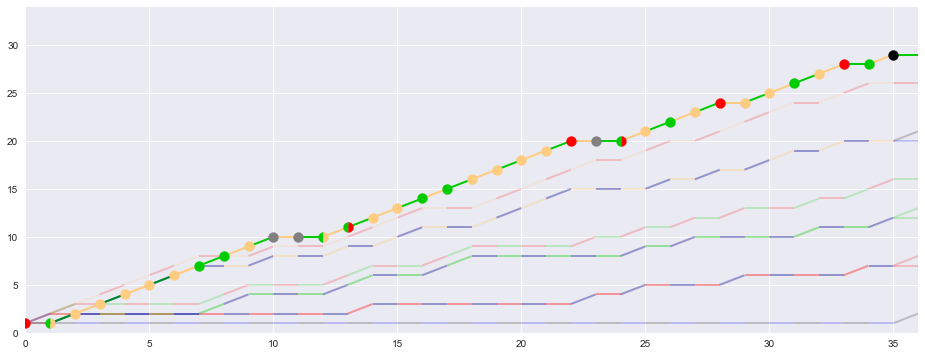

In [44]:
fig, ax = plt.subplots(figsize=(16, 6))

history_df = history_to_dataframe(drafter._archytype_preferences_history)
card_colors = [card['colorIdentity'] for card in drafter.cards]

winning_archytype = history_df.max().idxmax()
winning_history = history_df.loc[:, winning_archytype]

colors = make_archytype_colors(winning_archytype, alpha=1.0)
plot_alternating_color_line(ax, winning_history.index.values, winning_history.values, colors)

for arch in set(history_df.columns) - set([winning_archytype]):
    arch_history = history_df.loc[:, arch]
    colors = make_archytype_colors(arch, alpha=0.2)
    plot_alternating_color_line(ax, arch_history.index.values, arch_history.values, colors)

for color_pair, x, y in zip(card_colors, winning_history.index.values, winning_history.values):
    plot_color_identity_dot(ax, x, y, color_pair)    

    ax.set_xlim(0, 36)
ax.set_ylim(0, 34)